In [1]:
pip install tabgan==1.3.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.2 MB/s eta 0:00:00:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 78.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 63.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 15.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 19.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━

In [2]:
!pip install lightgbm

In [3]:
pip install --upgrade pandas "dask[complete]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 23.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.6/183.6 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.0
    Uninstalling pandas-2.2.0:
      Successfully uninstalled pandas-2.2.0
  Attempting uninstall: dask
    Found existing installation: dask 2024.1.1
    Uninstalling dask-2024.1.1:
      Successfully uninstalled dask-2024.1.1
  Attempting uninstall: distributed
    Found existing installation: distributed 2024.1.1
    Uninstalling distributed-2024.1.1:
      Successfully uninstalled distributed-2024.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
auto

In [4]:
## librerias requeridas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
#from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
#from scikitplot.metrics import plot_lift_curve
#from scikitplot.helpers import binary_ks_curve 
#from scikitplot.metrics import plot_ks_statistic
#from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [5]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/Target2"
dfTrain = pd.read_parquet(f"s3://{s3_url}/Train/Train.parquet")
tgTrain = dfTrain['target']

dfVal = pd.read_parquet(f"s3://{s3_url}/Validation/Validation.parquet")
tgVal = dfVal['target']

In [6]:
var_input = ['01_receiver_transaction_count', '01_sender_sending_days', '01_branch_working_days', '01_net_amount_receiver', 
         '01_sender_minutes_since_last_transaction_2days', '01_sender_minutes_since_last_transaction_1day', 
         '01_sender_days_to_last_transaction_365', 'sender_days_to_last_transaction_more365',
        'id_payout_A', 'id_payout_C', 'id_payout_D', 'id_payout_M', 'id_payout_N', 'id_payout_O', 
         'id_payout_P', 'id_payout_S', 'id_payout_T', 'id_payout_X']


In [7]:
dfTrain.shape

(15436388, 37)

In [8]:
#Ya lo traje dividido en conjuntos de entrenamiento (70%) y prueba (30%)

X_train = dfTrain[var_input]
X_test = dfVal[var_input]
y_train =  dfTrain['target']
y_test =  dfVal['target']

#Uni test y Val
X = pd.concat([dfTrain[var_input], dfVal[var_input]], ignore_index=True) 
Y = pd.DataFrame(pd.concat([dfTrain['target'], dfVal['target']], ignore_index=True)) 

In [9]:
def calcular_porcentaje_valor_1(columna):
    """
    Calcula el porcentaje de ocurrencia del valor 1 en una columna dicotómica.

    Parameters:
    - columna: Columna con valores binarios (0 o 1).

    Returns:
    - Porcentaje de ocurrencia del valor 1.
    """

    total_registros = len(columna)
    ocurrencias_valor_1 = columna.sum()

    porcentaje_valor_1 = (ocurrencias_valor_1 / total_registros) * 100

    return porcentaje_valor_1
porcentaje_1 = calcular_porcentaje_valor_1(Y['target'])
porcentaje_1

0.003237803909163003

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 88)

param_testeo = {
    "n_estimators": [15,20,25,30,35,40,45,50,60,70,80,90,100,150,200],
    "max_depth": [10,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,35,40,45,50], 
    "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
#     "min_samples_split ": [2,3,4,5,6,7,8,9,10,11,12,13,14,15],
    'max_features': ["auto","sqrt","log2"],
    "criterion": ["gini", "entropy"],
    }
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
n_HP_points_to_test = 100

rf = RandomForestClassifier(random_state=88)
result_trainRandom = RandomizedSearchCV(
                    estimator=rf, 
                    param_distributions=param_testeo, 
                    n_iter=n_HP_points_to_test,
                    scoring='recall',
                    cv=3,
                    refit=True,
                    random_state=88,
                    verbose=True,
                    n_jobs=-1)

result_trainRandom.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vec

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=88),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 15, 16, 17, 18, 19,
                                                      20, 21, 22, 23, 24, 25,
                                                      26, 27, 28, 29, 30, 35,
                                                      40, 45, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15],
                                        'n_estimators': [15, 20, 25, 30, 35, 40,
                                                         45, 50, 60, 70, 80, 90,
                                                         100, 150, 200]},
                   random_state=88, scoring='recall', verbose=True)

In [11]:
print(result_trainRandom)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=88),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 15, 16, 17, 18, 19,
                                                      20, 21, 22, 23, 24, 25,
                                                      26, 27, 28, 29, 30, 35,
                                                      40, 45, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15],
                                        'n_estimators': [15, 20, 25, 30, 35, 40,
                                                    

In [12]:
# Realizar predicciones con el modelo entrenado en el conjunto de entrenamiento
data1_f_data_pred_rf = result_trainRandom.predict(X)

# Obtener las probabilidades predichas para la clase positiva (clase 1) del modelo
probab_rf = result_trainRandom.predict_proba(X)

# Extraer las puntuaciones (probabilidades) asociadas con la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Crear una copia de las etiquetas verdaderas (Y) para análisis adicional
Y_c = Y.copy()

# Agregar las predicciones y las puntuaciones del modelo a las etiquetas verdaderas
Y_c['preds_rf'] = data1_f_data_pred_rf
Y_c['score_rf'] = score_rf

# Los datos ahora contienen etiquetas verdaderas, predicciones y puntuaciones del modelo
# Puedes utilizar estos resultados para realizar análisis y evaluar el rendimiento del modelo.


## Evaluo resultados

In [13]:
Y_c['score_rf'].quantile(0.999)
np.percentile(Y_c['score_rf'], [25,50,75])

array([0., 0., 0.])

In [14]:
Y_c['preds_rf'].value_counts()

preds_rf
False    22051406
True          578
Name: count, dtype: int64

<Axes: xlabel='score_rf', ylabel='Count'>

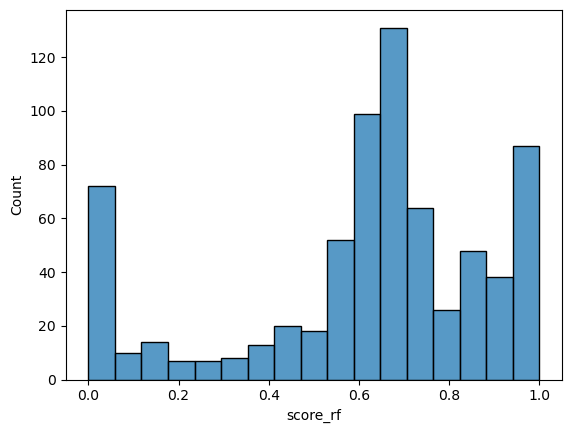

In [15]:
import seaborn as sns
sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [16]:
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,22051245,25
1,161,553


In [17]:
target_names = ['No fraude', 'Fraude']
print(classification_report(Y_c['target'], Y_c['preds_rf'], target_names=target_names))

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00  22051270
      Fraude       0.96      0.77      0.86       714

    accuracy                           1.00  22051984
   macro avg       0.98      0.89      0.93  22051984
weighted avg       1.00      1.00      1.00  22051984



In [18]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_c['score_rf'], q=10, duplicates='drop').astype(str)

percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
Y_c['FRAUD_DECILE'] = percentiles
print('FRAUD CAPTURA 30%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_c['target']))

FRAUD CAPTURA 30%:
1.0


In [19]:
DECILES_T = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])

In [20]:
DECILES_T

target,False,True
FRAUD_DECILE,,
1,22051270,714


array([<Axes: title={'center': 'False'}, xlabel='FRAUD_DECILE'>,
       <Axes: title={'center': 'True'}, xlabel='FRAUD_DECILE'>],
      dtype=object)

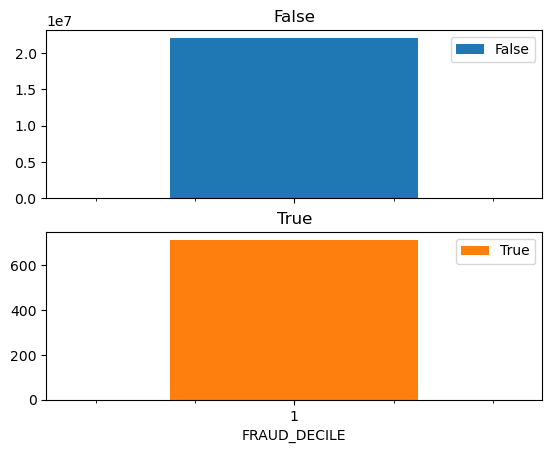

In [21]:
DECILES_T.plot.bar(stacked=False, rot=0,subplots=True)

## Veo en el test

In [22]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/Target2"
tes = pd.read_parquet(f"s3://{s3_url}/Test/Test.parquet")

##lista de variables de input
X = tes[var_input]
Y = tes[['target']] 


In [23]:
testeo = tes

In [24]:
testeo = testeo
#testeo['ID']=testeo['cbs_reg_user_id_cd']
#testeo = testeo.set_index('ID')  
#testeo=testeo.round(2)

 
print ("Dataset Length: ", len(testeo)) 
print ("Dataset Shape: ", testeo.shape)

Dataset Length:  14948154
Dataset Shape:  (14948154, 38)


In [25]:
testeo['target'].value_counts(dropna=False)

target
False    14947939
True          215
Name: count, dtype: int64

In [26]:
## Variables del modelo
X_TESTEO = tes[var_input]

In [27]:

# Extrayendo la columna 'target' del DataFrame 'testeo' y creando un nuevo DataFrame 'Y_TESTEO'
Y_TESTEO = testeo[['target']]

# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = result_trainRandom.predict(X_TESTEO)

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = result_trainRandom.predict_proba(X_TESTEO)

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [28]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_TESTEO_c = Y_TESTEO.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_TESTEO_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_TESTEO_c['score_rf'] = score_rf

In [ ]:
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

In [29]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_TESTEO_c['score_rf'], q=100, duplicates='drop').astype(str)
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_TESTEO_c['FRAUD_DECILE'] = np.nan
Y_TESTEO_c['FRAUD_DECILE'] = Y_TESTEO_c['FRAUD_DECILE'].astype('Int32')
Y_TESTEO_c['FRAUD_DECILE'] = percentiles
print('FRAUD CAPTURA 30%:')
print(sum(Y_TESTEO_c[Y_TESTEO_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_TESTEO_c['target']))
#Y_TESTEO_c.to_csv(r'./SCORES/primera_prueba.csv')

FRAUD CAPTURA 30%:
1.0


In [30]:
DECILES = pd.crosstab(Y_TESTEO_c['FRAUD_DECILE'], Y_TESTEO_c['target'])

In [31]:
DECILES

target,False,True
FRAUD_DECILE,,
1,14947939,215


array([<Axes: title={'center': 'False'}, xlabel='FRAUD_DECILE'>,
       <Axes: title={'center': 'True'}, xlabel='FRAUD_DECILE'>],
      dtype=object)

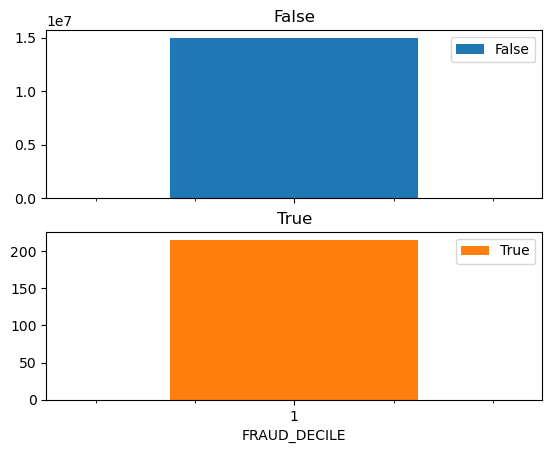

In [32]:
DECILES.plot.bar(stacked=False, rot=0,subplots=True)

In [33]:
Fin

NameError: name 'Fin' is not defined

## Guardo el modelo

In [ ]:
import joblib
# save model
joblib.dump(result_trainRandom, 'RandFT1.pkl')


In [ ]:
lgb_classifier = RandomForestClassifier(n_estimators=200,
                               bootstrap = True,
                               max_features = "auto", criterion = "entropy",  max_depth =22,min_samples_leaf=1)	


lgb_classifier.fit(np.array(X_train), y_train)